In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/uci_har_train_preprocessed.csv')
test_data = pd.read_csv('/content/drive/My Drive/uci_har_test_preprocessed.csv')

X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]
X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels:\n", y_train.value_counts())
print("Test labels:\n", y_test.value_counts())

Training data shape: (7352, 561)
Test data shape: (2947, 561)
Training labels:
 label
laying                1407
standing              1374
sitting               1286
walking               1226
walking_upstairs      1073
walking_downstairs     986
Name: count, dtype: int64
Test labels:
 label
laying                537
standing              532
walking               496
sitting               491
walking_upstairs      471
walking_downstairs    420
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

print("Reshaped training data shape:", X_train_reshaped.shape)
print("Reshaped test data shape:", X_test_reshaped.shape)

Reshaped training data shape: (7352, 1, 561)
Reshaped test data shape: (2947, 1, 561)


In [16]:
input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])) 

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(input_layer)
lstm_out = Dropout(0.3)(lstm_out)

# Directly connect to the next LSTM layer
lstm_out_2 = LSTM(64, return_sequences=False)(lstm_out)
lstm_out_2 = Dropout(0.3)(lstm_out_2)

# Fully connected layers
dense_1 = Dense(32, activation='relu')(lstm_out_2)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1, 561)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 128)              │         353,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,966 (1.54 MB)

 Trainable params: 404,966 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_categorical,
    validation_data=(X_test_reshaped, y_test_categorical),
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.6867 - loss: 1.0311 - val_accuracy: 0.9223 - val_loss: 0.2152
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9456 - loss: 0.1492 - val_accuracy: 0.9325 - val_loss: 0.1848
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9697 - loss: 0.0869 - val_accuracy: 0.9376 - val_loss: 0.1817
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9661 - loss: 0.0913 - val_accuracy: 0.9399 - val_loss: 0.1820
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9779 - loss: 0.0645 - val_accuracy: 0.9301 - val_loss: 0.2460
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9785 - loss: 0.0633 - val_accuracy: 0.9386 - val_loss: 0.2031
Epoch 7/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9774 - loss: 0.0579 - val_accuracy: 0.9410 - val_loss: 0.1838
Epoch 8/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9838 - loss: 0.0482 - val_acc

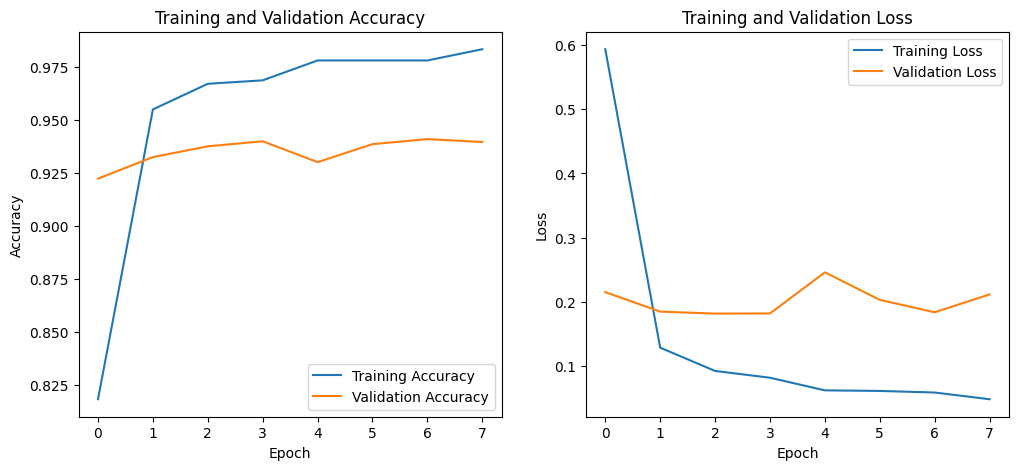

In [18]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9441 - loss: 0.1496
Test Loss: 0.1817183941602707
Test Accuracy: 0.9375635981559753
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
                    precision    recall  f1-score   support

            laying       1.00      0.97      0.98       537
           sitting       0.90      0.91      0.90       491
          standing       0.90      0.91      0.91       532
           walking       0.97      0.95      0.96       496
walking_downstairs       0.99      0.89      0.93       420
  walking_upstairs       0.88      0.99      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



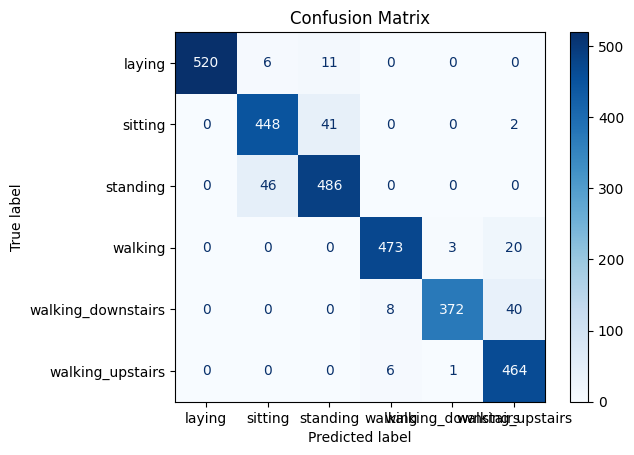

In [20]:
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()